In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

# Raw data

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L2.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = ['C11_10' if i=='11_10' else i for i in data.columns]
data = data/data.sum()*100.
data.shape
data.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(39, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Proteobacteria,56.984050,4.768908,4.774137,9.263585,2.459016,1.001965,12.761763,76.740108,39.740848,5.308804,...,0.420738,0.460987,2.092012,6.938648,1.564905,2.900941,52.485856,3.481986,0.820136,0.780416
k__Bacteria;p__Firmicutes,42.854841,14.096639,7.273980,2.353356,5.696345,6.586444,2.860773,19.364184,10.618372,5.706777,...,59.174810,74.509134,85.700054,53.422371,40.046178,15.908908,13.260758,9.786907,54.800622,62.760139


# 1. Change of top four phylums

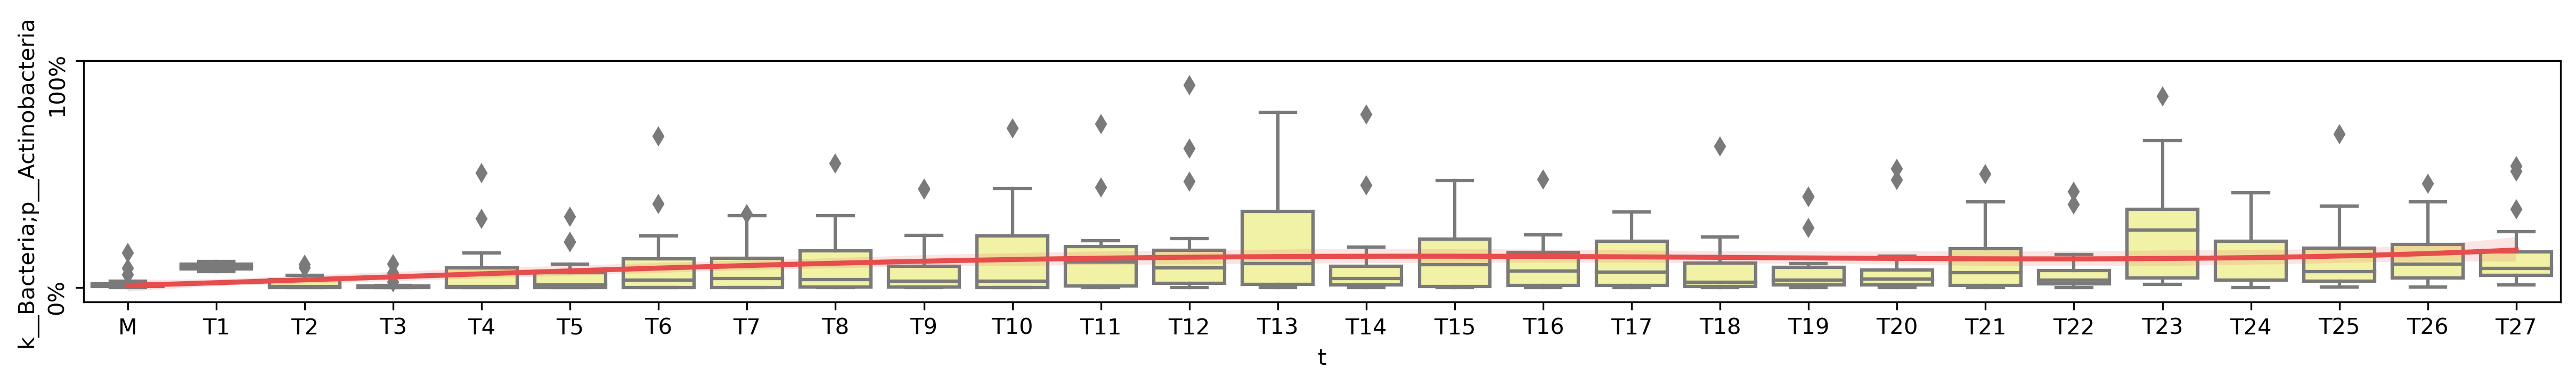

In [5]:
Times = ['M', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
pdata = data.iloc[:5, :].T
pdata['Time'] = meta.loc[pdata.index, 'Time']
pdata['t'] = [0 if i=='M' else int(i[1:]) for i in pdata['Time']]
taxa = 'k__Bacteria;p__Actinobacteria'
color = {'k__Bacteria;p__Firmicutes':'#7FC97F', 'k__Bacteria;p__Proteobacteria':'#BEAED4', 
         'k__Bacteria;p__Bacteroidetes':'#FDC086', 'k__Bacteria;p__Actinobacteria':'#FFFF99'}
fig = plt.figure(figsize=(20, 2), dpi=300)
_ = sns.boxplot(x='Time', y=taxa, data=pdata, orient="v", order=Times, color=color[taxa])
ax = sns.regplot(x='t', y=taxa, data=pdata, order=4, ci=95, scatter=False, n_boot=1000, color='#E64D4D', 
                 line_kws={'zorder':9})
#_ = ax.spines['top'].set_visible(False)
#_ = ax.spines['right'].set_visible(False)
#_ = ax.spines['bottom'].set_visible(False)
#_ = ax.get_xaxis().set_visible(False)
_ = plt.yticks([0, 100], ['0%', '100%'], rotation=90)
#fig.savefig('../Results_0609/2.1. '+taxa+'.pdf', dpi=300)

In [3]:
psum = data.loc[['k__Bacteria;p__Firmicutes', 'k__Bacteria;p__Proteobacteria', 
                 'k__Bacteria;p__Bacteroidetes', 'k__Bacteria;p__Actinobacteria'], :].sum()
psum.min()
psum.max()

39.37974683544304

100.00000000000003

In [16]:
data.loc['k__Bacteria;p__Firmicutes', [i for i in data.columns if '_27' in i]].mean()

25.312114348641916